# 2. Add tools

To handle queries that your chatbot can’t answer “from memory”, integrate a web search tool. The chatbot can use this tool to find relevant information and provide better responses.
This tutorial builds on [Build a Basic Chatbot](01_build_a_basic_chatbot.ipynb).

## Prerequisites

Before you start this tutorial, ensure you have the following:
- An API key for the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/).
​
## 1. Install the search engine

Install the requirements to use the Tavily Search Engine:

In [1]:
# pip install -U langchain-tavily

## 2. Configure your environment

Configure your environment with your search engine API key:

In [2]:
import os
import getpass

# Function to securely get Tavily API key
def get_tavily_api_key():
    """Securely prompt user for Tavily API key"""
    # First try to get from environment variable
    api_key = os.environ.get("TAVILY_API_KEY")
    
    if not api_key:
        print("Tavily API key not found in environment variables.")
        print("Please enter your Tavily API key:")
        print("Note: Your input will be hidden for security.")
        api_key = getpass.getpass("Tavily API Key: ")
        
        if api_key:
            # Set it for this session only
            os.environ["TAVILY_API_KEY"] = api_key
            print("API key set for this session.")
        else:
            raise ValueError("Tavily API key is required to run this chatbot.")
    
    return api_key

# Get the API key securely
api_key = get_tavily_api_key()

## 3. Define the tool

Define the web search tool:

In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by mode


## 4. Define the graph

For the StateGraph you created in the first tutorial, add bind_tools on the LLM. This lets the LLM know the correct JSON format to use if it wants to use the search engine.

Let’s first select our LLM:

In [4]:
# pip install -U "langchain[openai]"

In [5]:
import os
import getpass
from langchain.chat_models import init_chat_model

# Function to securely get OpenAI API key
def get_openai_api_key():
    """Securely prompt user for OpenAI API key"""
    # First try to get from environment variable
    api_key = os.environ.get("OPENAI_API_KEY")
    
    if not api_key:
        print("OpenAI API key not found in environment variables.")
        print("Please enter your OpenAI API key:")
        print("Note: Your input will be hidden for security.")
        api_key = getpass.getpass("OpenAI API Key: ")
        
        if api_key:
            # Set it for this session only
            os.environ["OPENAI_API_KEY"] = api_key
            print("API key set for this session.")
        else:
            raise ValueError("OpenAI API key is required to run this chatbot.")
    
    return api_key

# Get the API key securely
api_key = get_openai_api_key()

# Initialize the chat model
llm = init_chat_model("openai:gpt-4.1")

We can now incorporate it into a StateGraph:

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## 5. Create a function to run the tools

Now, create a function to run the tools if they are called. Do this by adding the tools to a new node calledBasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM’s tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [7]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

If you do not want to build this yourself in the future, you can use LangGraph’s prebuilt ToolNode.

## 6. Define the conditional_edges

With the tool node added, now you can define the conditional_edges.

Edges route the control flow from one node to the next. Conditional edges start from a single node and usually contain “if” statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Next, define a router function called route_tools that checks for tool_calls in the chatbot’s output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not. Because the condition can return END, you do not need to explicitly set a finish_point this time.

In [8]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

You can replace this with the prebuilt tools_condition to be more concise.
​
## 7. Visualize the graph

You can visualize the graph using the get_graph method and one of the “draw” methods, like draw_ascii or draw_png. The draw methods each require additional dependencies.

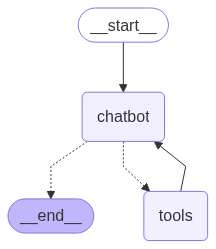

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 8. Ask the bot questions

Now you can ask the chatbot questions outside its training data:

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph?", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [...] Agent systems: LangGraph provides a framework for building agent-based systems, which can be used in applications such as robotics, autonomous vehicles or video games.\n\nLLM applications: By using LangGraph\u2019s capabilities, developers can build more sophisticated AI models that learn and improve over time. No